# 数据前处理和可视化
## 1. 数据集下载并解压  
在当前目录下, 建立./Dataset目录, 将从Kaggle上下载的训练数据集train.zip和测试数据集test.zip放到./Dataset目录下, 并解压到./Dataset目录

数据集下载：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

## 2. 数据探索
读取训练数据集和测试数据集列表并随机选一些图像进行显示
可以看到训练数据一共25000个, dog和cat图片放在一个文件夹中, 标签用图片名表示
测试数据一共12500个, 名称中没有包含标签

### 载入必要的库

In [4]:
from matplotlib import pyplot as plt
import cv2
import os
import random 
import shutil

### 数据可视化

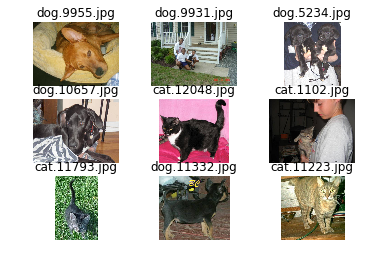

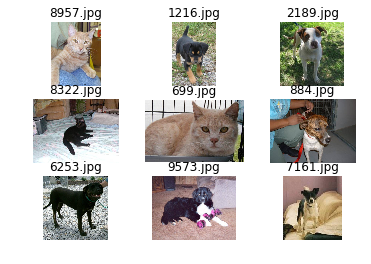

train data samples:25000
test data samples:12500


In [5]:
%matplotlib inline

train_path = './Dataset/train'
test_path = './Dataset/test'

train_list = os.listdir(train_path)
test_list = os.listdir(test_path)

random.shuffle(train_list)
random.shuffle(test_list)

plotloc = [331, 332, 333, 334, 335, 336, 337, 338, 339]

for idx, fname in enumerate(train_list):
    if idx >= 9:
        break
    img_name = os.path.join(train_path, fname)
    img = cv2.imread(img_name)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.subplot(plotloc[idx])
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
plt.show()

for idx, fname in enumerate(test_list):
    if idx >= 9:
        break
    img_name = os.path.join(test_path, fname)
    img = cv2.imread(img_name)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.subplot(plotloc[idx])
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
plt.show()

print("train data samples:%d" % (train_list.__len__()))
print("test data samples:%d" % (test_list.__len__()))

## 3. 数据库整理
将训练数据集的dog和cat图片放到不同的文件夹中
将测试数据集的所有图片放在同一个文件夹中, 目录深度和训练数据集保持一致

In [6]:
train_path = './Dataset/train'
train_list = os.listdir(train_path)

os.mkdir('./Dataset/train/dog')
os.mkdir('./Dataset/train/cat')

for f in train_list:
    old_filepath = os.path.join(train_path, f)
    if 'dog' in f:
        new_filepath = os.path.join('./Dataset/train/dog', f)
    else:
        new_filepath = os.path.join('./Dataset/train/cat', f)
    shutil.move(old_filepath, new_filepath)

os.mkdir('./Dataset/test2')
shutil.move('./Dataset/test', './Dataset/test2')

'./Dataset/test2/test'

## 4. 异常数据清理
先用Xception, InceptionV3, InceptionResNetV2三个已经在ImageNet上训练过的模型进行预测, 挑出与标签不符的数据, 再人工将这些与标签不符的数据中的误判异常放回训练集中

### 载入必要的库

In [7]:
from keras.applications import inception_v3
from keras.applications import inception_resnet_v2
from keras.applications import xception

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

import random
import shutil

### 定义ImageNet中猫狗的分类标签和参数

In [36]:
dogs = [
    'n02085620', 'n02085782', 'n02085936', 'n02086079',
    'n02086240', 'n02086646', 'n02086910', 'n02087046',
    'n02087394', 'n02088094', 'n02088238', 'n02088364',
    'n02088466', 'n02088632', 'n02089078', 'n02089867',
    'n02089973', 'n02090379', 'n02090622', 'n02090721',
    'n02091032', 'n02091134', 'n02091244', 'n02091467',
    'n02091635', 'n02091831', 'n02092002', 'n02092339',
    'n02093256', 'n02093428', 'n02093647', 'n02093754',
    'n02093859', 'n02093991', 'n02094114', 'n02094258',
    'n02094433', 'n02095314', 'n02095570', 'n02095889',
    'n02096051', 'n02096177', 'n02096294', 'n02096437',
    'n02096585', 'n02097047', 'n02097130', 'n02097209',
    'n02097298', 'n02097474', 'n02097658', 'n02098105',
    'n02098286', 'n02098413', 'n02099267', 'n02099429',
    'n02099601', 'n02099712', 'n02099849', 'n02100236',
    'n02100583', 'n02100735', 'n02100877', 'n02101006',
    'n02101388', 'n02101556', 'n02102040', 'n02102177',
    'n02102318', 'n02102480', 'n02102973', 'n02104029',
    'n02104365', 'n02105056', 'n02105162', 'n02105251',
    'n02105412', 'n02105505', 'n02105641', 'n02105855',
    'n02106030', 'n02106166', 'n02106382', 'n02106550',
    'n02106662', 'n02107142', 'n02107312', 'n02107574',
    'n02107683', 'n02107908', 'n02108000', 'n02108089',
    'n02108422', 'n02108551', 'n02108915', 'n02109047',
    'n02109525', 'n02109961', 'n02110063', 'n02110185',
    'n02110341', 'n02110627', 'n02110806', 'n02110958',
    'n02111129', 'n02111277', 'n02111500', 'n02111889',
    'n02112018', 'n02112137', 'n02112350', 'n02112706',
    'n02113023', 'n02113186', 'n02113624', 'n02113712',
    'n02113799', 'n02113978']

cats = [
    'n02123045', 'n02123159', 'n02123394', 'n02123597',
    'n02124075', 'n02125311', 'n02127052']

dog_train_path = './Dataset/train/dog'
cat_train_path = './Dataset/train/cat'
dog_train_list = os.listdir(dog_train_path)
cat_train_list = os.listdir(cat_train_path)

random.shuffle(dog_train_list)
random.shuffle(cat_train_list)
abnormal_path = './Dataset/train/abnormal'

sample_rate = 1
dog_top_n = 5
cat_top_n = 20
plt_column = 5

### 定义清理异常数据函数

In [37]:
def abnormal_reject(MODEL, image_size, preprocess_func):
    model = MODEL(weights='imagenet')
    dog_abnormal_list = []
    cat_abnormal_list = []

    # train dog clean
    for idx, f in tqdm(enumerate(dog_train_list)):
        if not idx % sample_rate == 0:
            continue

        img_path = os.path.join(dog_train_path, f)
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_func(x)

        preds = model.predict(x)
        preds_list = decode_predictions(preds, top=dog_top_n)[0]

        match = False
        for pr in preds_list:
            if pr[0] in dogs:
                match = True
                break
        if not match:
            dog_abnormal_list.append(f)
            shutil.move(os.path.join(dog_train_path, f), os.path.join(abnormal_path, f))

    for ab_idx, abnormal_img in enumerate(dog_abnormal_list):
        dog_train_list.remove(abnormal_img)
        if ab_idx < 9:
            img = Image.open(os.path.join(abnormal_path, abnormal_img))
            plt.subplot(3, 3, ab_idx+1)
            plt.imshow(img)
            plt.title(abnormal_img)
            plt.axis('off')
        

    fig = plt.figure()
    # train cat clean
    for idx, f in tqdm(enumerate(cat_train_list)):
        if not idx % sample_rate == 0:
            continue

        img_path = os.path.join(cat_train_path, f)
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_func(x)

        preds = model.predict(x)
        preds_list = decode_predictions(preds, top=cat_top_n)[0]

        match = False
        for pr in preds_list:
            if pr[0] in cats:
                match = True
                break
        if not match:
            cat_abnormal_list.append(f)
            shutil.move(os.path.join(cat_train_path, f), os.path.join(abnormal_path, f))

    for ab_idx, abnormal_img in enumerate(cat_abnormal_list):
        cat_train_list.remove(abnormal_img)
        if ab_idx < 9:
            img = Image.open(os.path.join(abnormal_path, abnormal_img))
            plt.subplot(3, 3, ab_idx+1)
            plt.imshow(img)
            plt.title(abnormal_img)
            plt.axis('off')

    plt.show()

### 执行异常数据清理

12500it [03:31, 59.21it/s]
12500it [03:30, 59.44it/s]


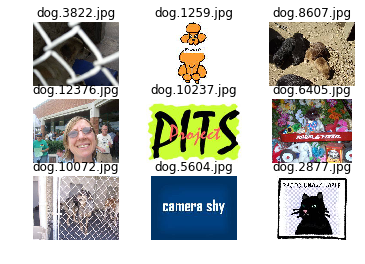

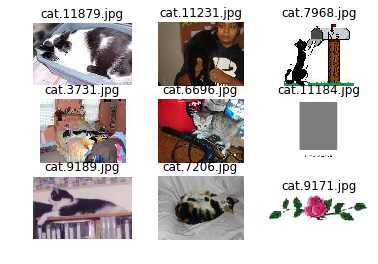

12441it [04:28, 46.40it/s]
12373it [04:25, 46.64it/s]


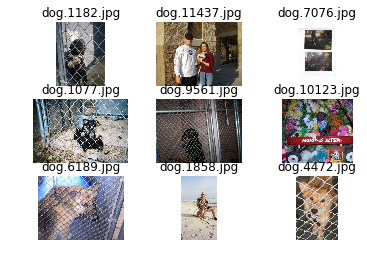

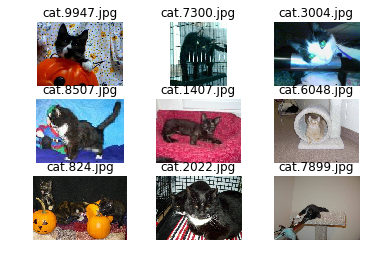

225214464/225209952 [==============================] - 888s 4us/step


12407it [07:23, 27.98it/s]
12255it [07:14, 28.20it/s]


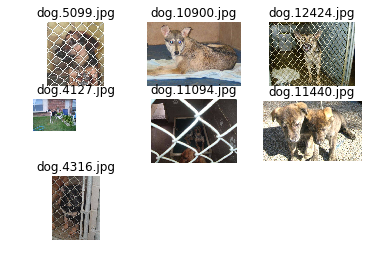

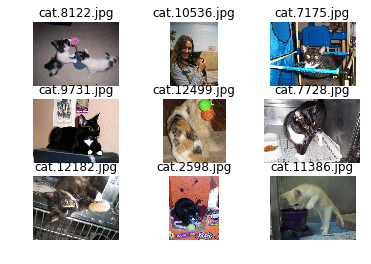

In [38]:
os.mkdir(abnormal_path)
abnormal_reject(xception.Xception, (299, 299), xception.preprocess_input)
abnormal_reject(inception_v3.InceptionV3, (299, 299), inception_v3.preprocess_input)
abnormal_reject(inception_resnet_v2.InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)

按照上面的方法, 一共挑出来407个疑似异常数据, 经过人工筛选后, 认为有102个不应该放入训练样本集的异常数据, 将这些确认的异常数据整理出异常数据列表abnormal_list.txt, 留下在训练模型时用, 为保证整个项目过程的统一, 整理出列表后, 再将移除的所有407个疑似异常数据放回样本集中。

In [40]:
abnormal_path = './Dataset/train/abnormal'
abnormal_list = os.listdir(abnormal_path)
for fname in abnormal_list:
    if 'dog' in fname:
        shutil.move(os.path.join(abnormal_path, fname), os.path.join(dog_train_path, fname))
    else:
        shutil.move(os.path.join(abnormal_path, fname), os.path.join(cat_train_path, fname))
os.rmdir(abnormal_path)